In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

$\textbf{Introduction}$

- We examine data compression tools of the PCA and the Neural Network Autoencoder
- We examine their performance both with training data and out of sample test set data
- One of the key lessons is that for the nonlinear method, it is very important to squash the data
- Otherwise the optimal parameters will likely not converge to the minimum sum of squared errors
- We read in a large spread sheet with Hong Kong and US Swap Option volatilities for various maturieis
- Obivously there are more swap option volatility quotes for the US than for Hong Kong
- We should like to know how they interrelate and influence one another
- Since Hong Kong has a credible fixed exchange rate with the US dollar, any differences would not be due to currency risk
- Significnat differences would relect $\textit{idiosyncratic risk}$.


        Date  HDSV0A2 Curncy  HDSV0A1 Curncy  HDSV0210 Curncy  HDSV101 Curncy  \
0 2005-05-25            30.5            37.5            18.70           18.00   
1 2005-05-26            31.5            37.5            18.80           18.00   
2 2005-05-27            30.5            36.0            18.80           17.90   
3 2005-05-30            31.0            35.5            18.80           17.90   
4 2005-05-31            30.5            35.0            18.85           18.05   

   HDSV015 Curncy  HDSV0110 Curncy  HDSV0C2 Curncy  USSN0C10 Curncy  \
0           23.60            20.00           30.70            83.60   
1           23.60            20.10           30.30            83.60   
2           23.60            20.20           30.60            82.15   
3           23.60            20.10           30.60            82.15   
4           22.55            18.75           28.75            83.30   

   USSN0110 Curncy  ...  USSN036 Curncy  USSN038 Curncy  USSN039 Curncy  \
0          

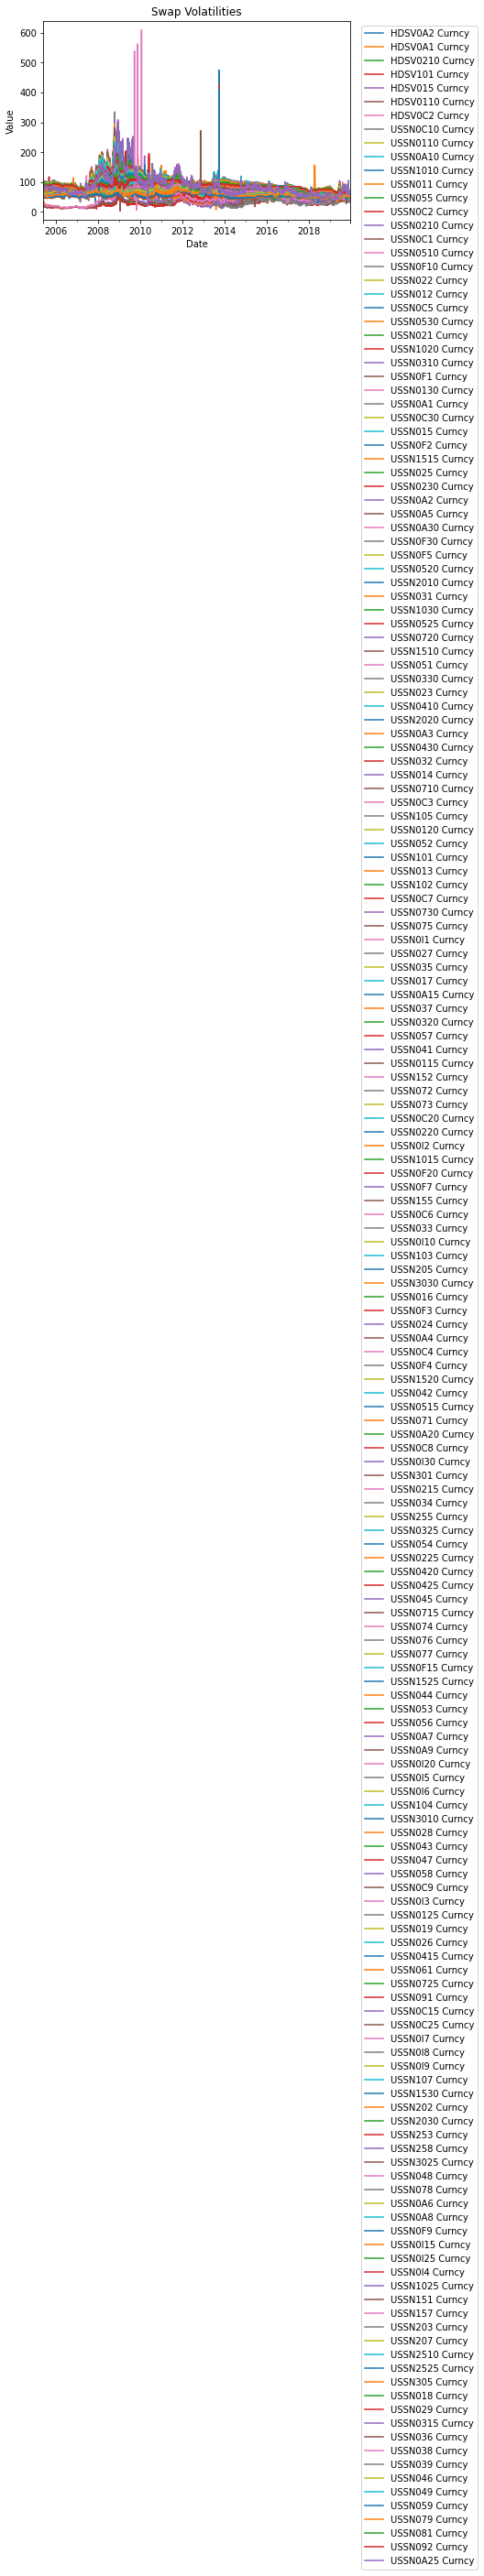

In [2]:
df = pd.read_excel('HKSwap2.xlsx', parse_dates=[0]) 
print(df.head())
#df = pd.read_excel('USInterestRate.xlsx', parse_dates=['Date'])

# Set the index of the DataFrame to the date column
df.set_index('Date', inplace=True)

# Plot the DataFrame using Matplotlib
df.plot()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Swap Volatilities')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.show()

In [3]:
import matplotlib.pyplot as plt

- We normalize the data between zero and one.  
- It does no harm to the linear estimation since we do a linear transformation
- It saves a lot of time and speeds up convergence in nonlinear estimation
- We can also standarize the data or do a normalization in the interval [-1,1]
- You can check if alternative normalization makes any difference
- We use the MinMaxScaler below for (0,1) but you can change it to (-1,1)

 - We will pull out the HK and US data and do a full-sample analysis of the performance of models
 - We will then estimate with the training set data for both and then see how the models perform out-of-sample with test sets
 - We normalize the data between [0,1]
 - There is also the option to standarize the data sets
 - I leave it to you to test for the sensitivity of the alternative "squasher" functions.

In [4]:
X = df.iloc[:, 1:].values
Date = df.iloc[:,0].index
from sklearn.preprocessing import MinMaxScaler
# X_standardized is the standardized matrix
scaler = MinMaxScaler(feature_range=(0, 1))
X= scaler.fit_transform(X)
HK = X[:,:7]
USA = X[:,7:]
HKtrain, HKtest = train_test_split(HK, test_size=0.2, random_state=42)
USAtrain, USAtest = train_test_split(USA, test_size= 0.2, random_state=42)
print(HKtrain.shape)
print(HKtest.shape)

(3038, 7)
(760, 7)


$\textbf{Hong Kong Data}$

(3798, 7)


Text(0.5, 1.0, 'Hong Kong Swap Volatilities')

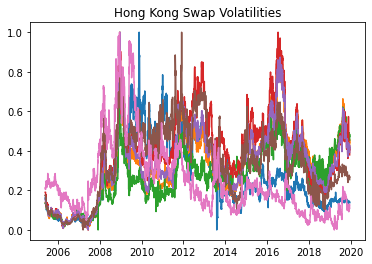

In [5]:
print(HK.shape)
plt.plot(Date,HK) 
plt.title('Hong Kong Swap Volatilities')

Text(0.5, 1.0, 'USA Swap Option Volatilities')

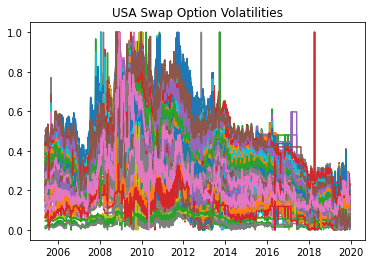

In [6]:
plt.plot(Date, USA)
plt.title('USA Swap Option Volatilities')

- We can see that the standard deviations are practically identical since the data are normalized.
- We import and use the PCA algorithm to examine the effectiveness for the first two principal components
- We do a scatter diagram to see that the two do not have a significant positive or negative correlation

In [7]:
Stats = np.std(HK,0)
StatsUS = np.std(USA,0)
print(np.max(Stats))
print(np.max(StatsUS))



0.20486869440186767
0.2032764279294758


In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
PC = pca.fit_transform(HK)

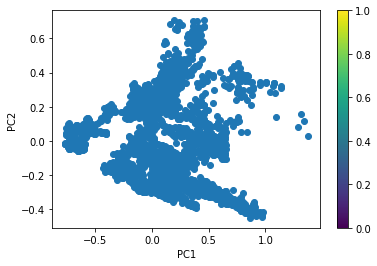

In [9]:
plt.scatter(PC[:,0], PC[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()


Text(0.5, 1.0, 'Principal Components for Hong Kong')

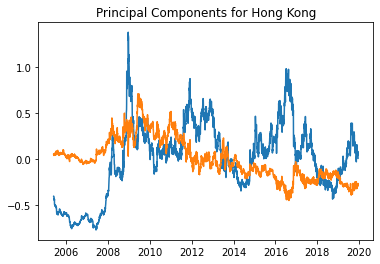

In [10]:
plt.plot(Date,PC)
plt.title('Principal Components for Hong Kong')

In [11]:
HKhat = pca.inverse_transform(PC)


Text(0.5, 1.0, 'Predicted Values for HK')

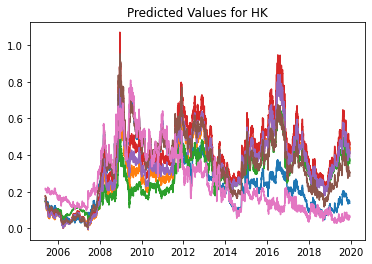

In [12]:
plt.plot(Date, HKhat)
plt.title('Predicted Values for HK')

78.66233725446507


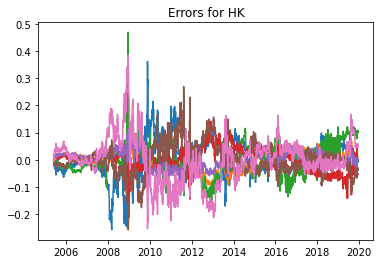

In [13]:
ERROR = HK - HKhat
plt.plot(Date,ERROR)
plt.title('Errors for HK')
SEE = np.sum(ERROR**2,axis=0)
SEE1 = np.sum(SEE)
print(SEE1)

In [14]:
variance_ratio = pca.explained_variance_ratio_
junk = np.var(HKhat,0)
junk1 = np.var(HK,0)
RSQ_PC_HK = junk/junk1
print(RSQ_PC_HK)
print(np.min(RSQ_PC_HK))
# Calculate the total percentage of the variance captured by the first two principal components
total_variance = np.sum(variance_ratio[:2])
percent_total_variance = total_variance * 100

print(f'The first two principal components explain {percent_total_variance:.2f} of the total variance')





[0.85894373 0.96162456 0.84353158 0.95964647 0.97622294 0.91419614
 0.80602972]
0.8060297201310828
The first two principal components explain 90.80 of the total variance


 - We now do the out-of-sample statistics
 - We first fit the training set for the two components
 - We then find, after fitting, the transformation for the test data
 - We then see how the fitted PC's explain the out-of-sample data
 - We keep the errors and the root mean squared errors for the seven series

In [15]:
pca1 = PCA(n_components=2)
HK_train = pd.DataFrame(HKtrain)
HK_test  = pd.DataFrame(HKtest)
HK_train_pca = pca1.fit_transform(HK_train)
HK_test_pca = pca1.transform(HK_test)
HK_out = pca1.inverse_transform(HK_test_pca)
HK_ERROR = HK_test - HK_out
HK_ERROR2 = HK_ERROR**2
HK_ERROR2M = HK_ERROR2.mean(axis=0)
HK_RMSQ = HK_ERROR2M**.5
print(HK_RMSQ)


0    0.066872
1    0.034134
2    0.052960
3    0.039204
4    0.027026
5    0.053986
6    0.077972
dtype: float64


-
- Now lets try an autoencoder neural network
- Network structure is [20-10-2-10-20]
- Two layers of encoders and two layers of decoders

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Load data into a NumPy array
# Define the dimensions of the input and latent spaces
input_dim = HK.shape[1]
latent_dim = 1

# Define the encoder
inputs = Input(shape=(input_dim,))
encoded = Dense(100, activation='relu')(inputs)
encoded = Dense(50, activation='relu')(encoded)
encoded = Dense(2, activation='relu')(encoded)
decoded = Dense(50, activation='relu')(encoded)
decoded = Dense(100, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

# Define the autoencoder
autoencoder = Model(inputs, decoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(HK, HK, epochs=1000)

# Extract the encoder model for dimensionality reduction
encoder = Model(inputs, encoded)
encoded_HK = encoder.predict(HK)




Epoch 1/1000
119/119 [==============================] - 1s 761us/step - loss: 0.0215
Epoch 2/1000
119/119 [==============================] - 0s 744us/step - loss: 0.0030
Epoch 3/1000
119/119 [==============================] - 0s 752us/step - loss: 0.0026
Epoch 4/1000
119/119 [==============================] - 0s 735us/step - loss: 0.0023
Epoch 5/1000
119/119 [==============================] - 0s 744us/step - loss: 0.0020
Epoch 6/1000
119/119 [==============================] - 0s 746us/step - loss: 0.0019
Epoch 7/1000
119/119 [==============================] - 0s 751us/step - loss: 0.0018
Epoch 8/1000
119/119 [==============================] - 0s 761us/step - loss: 0.0018
Epoch 9/1000
119/119 [==============================] - 0s 735us/step - loss: 0.0017
Epoch 10/1000
119/119 [==============================] - 0s 744us/step - loss: 0.0017
Epoch 11/1000
119/119 [==============================] - 0s 757us/step - loss: 0.0016
Epoch 12/1000
119/119 [==============================] - 0s 752

119/119 [==============================] - 0s 752us/step - loss: 8.6627e-04
Epoch 188/1000
119/119 [==============================] - 0s 727us/step - loss: 8.5166e-04
Epoch 189/1000
119/119 [==============================] - 0s 744us/step - loss: 8.5845e-04
Epoch 190/1000
119/119 [==============================] - 0s 778us/step - loss: 8.6076e-04
Epoch 191/1000
119/119 [==============================] - 0s 735us/step - loss: 8.5271e-04
Epoch 192/1000
119/119 [==============================] - 0s 752us/step - loss: 8.6598e-04
Epoch 193/1000
119/119 [==============================] - 0s 735us/step - loss: 8.5951e-04
Epoch 194/1000
119/119 [==============================] - 0s 735us/step - loss: 8.6434e-04
Epoch 195/1000
119/119 [==============================] - 0s 735us/step - loss: 8.5400e-04
Epoch 196/1000
119/119 [==============================] - 0s 752us/step - loss: 8.7045e-04
Epoch 197/1000
119/119 [==============================] - 0s 791us/step - loss: 8.4644e-04
Epoch 198/1000

119/119 [==============================] - 0s 735us/step - loss: 6.9561e-04
Epoch 368/1000
119/119 [==============================] - 0s 735us/step - loss: 7.0209e-04
Epoch 369/1000
119/119 [==============================] - 0s 752us/step - loss: 7.2386e-04
Epoch 370/1000
119/119 [==============================] - 0s 744us/step - loss: 6.9487e-04
Epoch 371/1000
119/119 [==============================] - 0s 735us/step - loss: 6.9598e-04
Epoch 372/1000
119/119 [==============================] - 0s 744us/step - loss: 6.9162e-04
Epoch 373/1000
119/119 [==============================] - 0s 735us/step - loss: 7.1390e-04
Epoch 374/1000
119/119 [==============================] - 0s 752us/step - loss: 6.9530e-04
Epoch 375/1000
119/119 [==============================] - 0s 744us/step - loss: 7.0180e-04
Epoch 376/1000
119/119 [==============================] - 0s 735us/step - loss: 6.9662e-04
Epoch 377/1000
119/119 [==============================] - 0s 727us/step - loss: 6.8689e-04
Epoch 378/1000

119/119 [==============================] - 0s 727us/step - loss: 6.2482e-04
Epoch 548/1000
119/119 [==============================] - 0s 727us/step - loss: 5.9868e-04
Epoch 549/1000
119/119 [==============================] - 0s 744us/step - loss: 6.1097e-04
Epoch 550/1000
119/119 [==============================] - 0s 744us/step - loss: 6.0843e-04
Epoch 551/1000
119/119 [==============================] - 0s 727us/step - loss: 6.6585e-04
Epoch 552/1000
119/119 [==============================] - 0s 744us/step - loss: 6.4788e-04
Epoch 553/1000
119/119 [==============================] - 0s 735us/step - loss: 6.2267e-04
Epoch 554/1000
119/119 [==============================] - 0s 744us/step - loss: 6.1841e-04
Epoch 555/1000
119/119 [==============================] - 0s 735us/step - loss: 6.1506e-04
Epoch 556/1000
119/119 [==============================] - 0s 778us/step - loss: 6.1236e-04
Epoch 557/1000
119/119 [==============================] - 0s 761us/step - loss: 6.1756e-04
Epoch 558/1000

119/119 [==============================] - 0s 735us/step - loss: 5.6406e-04
Epoch 728/1000
119/119 [==============================] - 0s 735us/step - loss: 5.6863e-04
Epoch 729/1000
119/119 [==============================] - 0s 727us/step - loss: 5.8601e-04
Epoch 730/1000
119/119 [==============================] - 0s 735us/step - loss: 5.5665e-04
Epoch 731/1000
119/119 [==============================] - 0s 735us/step - loss: 5.7762e-04
Epoch 732/1000
119/119 [==============================] - 0s 744us/step - loss: 5.6310e-04
Epoch 733/1000
119/119 [==============================] - 0s 735us/step - loss: 5.5757e-04
Epoch 734/1000
119/119 [==============================] - 0s 727us/step - loss: 5.6152e-04
Epoch 735/1000
119/119 [==============================] - 0s 727us/step - loss: 5.7437e-04
Epoch 736/1000
119/119 [==============================] - 0s 727us/step - loss: 5.8885e-04
Epoch 737/1000
119/119 [==============================] - 0s 727us/step - loss: 5.8905e-04
Epoch 738/1000

119/119 [==============================] - 0s 744us/step - loss: 5.4599e-04
Epoch 908/1000
119/119 [==============================] - 0s 735us/step - loss: 5.2004e-04
Epoch 909/1000
119/119 [==============================] - 0s 744us/step - loss: 5.3628e-04
Epoch 910/1000
119/119 [==============================] - 0s 744us/step - loss: 5.5110e-04
Epoch 911/1000
119/119 [==============================] - 0s 752us/step - loss: 5.8017e-04
Epoch 912/1000
119/119 [==============================] - 0s 752us/step - loss: 5.5709e-04
Epoch 913/1000
119/119 [==============================] - 0s 744us/step - loss: 5.3410e-04
Epoch 914/1000
119/119 [==============================] - 0s 752us/step - loss: 5.6012e-04
Epoch 915/1000
119/119 [==============================] - 0s 752us/step - loss: 5.3897e-04
Epoch 916/1000
119/119 [==============================] - 0s 778us/step - loss: 5.2052e-04
Epoch 917/1000
119/119 [==============================] - 0s 744us/step - loss: 5.2631e-04
Epoch 918/1000

In [25]:

# Extract the encoder model for dimensionality reduction
encoder = Model(inputs, encoded)
encoded_HK = encoder.predict(HK)

119/119 [==============================] - 0s 532us/step


In [26]:
HKhat1 = autoencoder.predict(HK)


119/119 [==============================] - 0s 569us/step


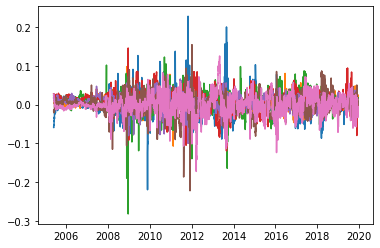

In [27]:
plt.plot(Date, HKhat1-HK)

In [28]:
junk = np.var(HKhat1,axis=0)

junk1 = np.var(HK, axis= 0)

ERROR = HKhat1 -HK
SEE = np.sum(ERROR**2, axis=0)
SEE1 = np.sum(SEE)
print(SEE1)
RSQ_HK_NPC = junk/junk1
print(RSQ_HK_NPC)
print(np.min(RSQ_HK_NPC))

# Format the dates as 'YYYY-MM-DD'


13.891135469066837
[0.99264928 0.97277927 0.99354759 0.96943587 0.95132456 0.98190514
 0.96582281]
0.9513245633778414


- We see that the min value of the NPC $R^2$ is .96, almost twice as good at the PC.  

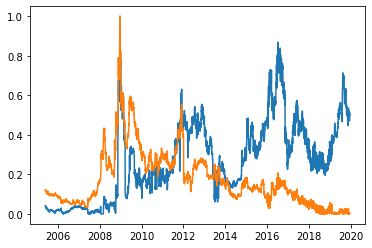

In [29]:
encoded_HK= scaler.fit_transform(encoded_HK)
plt.plot(Date, encoded_HK)

- We plot the difference between the PC and Autoencoded Signals

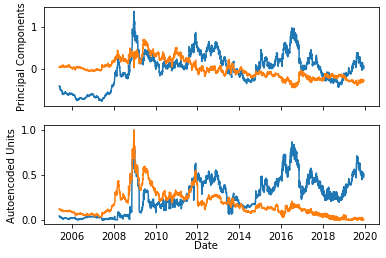

In [30]:

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Plot the first subplot
ax1.plot(Date, PC)
ax1.set_ylabel('Principal Components')

# Plot the second subplot
ax2.plot(Date, encoded_HK)
ax2.set_ylabel('Autoencoded Units')

# Add a common x-axis label
fig.text(0.5, 0.04, 'Date', ha='center')

# Set the y-axis limits to be the same on both subplots


plt.show()







In [31]:
print(np.std(encoded_HK,0))
print(np.std(PC,0))

[0.19684285 0.14156231]
[0.3942765  0.22138662]


- We see that the standard deviations are lower for the first two principal components of Autoencoder relative the PC.
- We also see the in-sample $R^2$ statistics for the Autoencoder relative to the PC
- Not suprisingly, the NPC always gives better in-sample performance.

In [32]:
print(RSQ_HK_NPC)
print(RSQ_PC_HK)

[0.99264928 0.97277927 0.99354759 0.96943587 0.95132456 0.98190514
 0.96582281]
[0.85894373 0.96162456 0.84353158 0.95964647 0.97622294 0.91419614
 0.80602972]


- Of course, the real proof of the pudding is in out of sample prediction, especially with rolling window regression.


- Let's train the autoencoder with the training set data and see how it performs on the test set data.

In [33]:
# Train the autoencoder
autoencoder.fit(HKtrain, HKtrain, epochs=1000)

# Extract the encoder model for dimensionality reduction
encoder = Model(inputs, encoded)
#encoded_HK = encoder.predict(HK)

Epoch 1/1000
95/95 [==============================] - 0s 802us/step - loss: 5.4546e-04
Epoch 2/1000
95/95 [==============================] - 0s 817us/step - loss: 5.0818e-04
Epoch 3/1000
95/95 [==============================] - 0s 753us/step - loss: 5.0478e-04
Epoch 4/1000
95/95 [==============================] - 0s 753us/step - loss: 5.1072e-04
Epoch 5/1000
95/95 [==============================] - 0s 778us/step - loss: 5.2740e-04
Epoch 6/1000
95/95 [==============================] - 0s 753us/step - loss: 5.1187e-04
Epoch 7/1000
95/95 [==============================] - 0s 764us/step - loss: 5.1179e-04
Epoch 8/1000
95/95 [==============================] - 0s 764us/step - loss: 5.0875e-04
Epoch 9/1000
95/95 [==============================] - 0s 785us/step - loss: 4.9812e-04
Epoch 10/1000
95/95 [==============================] - 0s 775us/step - loss: 4.9553e-04
Epoch 11/1000
95/95 [==============================] - 0s 764us/step - loss: 5.1251e-04
Epoch 12/1000
95/95 [====================

95/95 [==============================] - 0s 753us/step - loss: 4.9584e-04
Epoch 187/1000
95/95 [==============================] - 0s 753us/step - loss: 4.9011e-04
Epoch 188/1000
95/95 [==============================] - 0s 732us/step - loss: 4.9991e-04
Epoch 189/1000
95/95 [==============================] - 0s 732us/step - loss: 4.9491e-04
Epoch 190/1000
95/95 [==============================] - 0s 743us/step - loss: 4.9581e-04
Epoch 191/1000
95/95 [==============================] - 0s 764us/step - loss: 4.8831e-04
Epoch 192/1000
95/95 [==============================] - 0s 732us/step - loss: 4.9266e-04
Epoch 193/1000
95/95 [==============================] - 0s 743us/step - loss: 4.9726e-04
Epoch 194/1000
95/95 [==============================] - 0s 743us/step - loss: 4.7904e-04
Epoch 195/1000
95/95 [==============================] - 0s 743us/step - loss: 5.0565e-04
Epoch 196/1000
95/95 [==============================] - 0s 743us/step - loss: 4.8351e-04
Epoch 197/1000
95/95 [==============

95/95 [==============================] - 0s 753us/step - loss: 5.3422e-04
Epoch 371/1000
95/95 [==============================] - 0s 775us/step - loss: 4.9851e-04
Epoch 372/1000
95/95 [==============================] - 0s 743us/step - loss: 4.7453e-04
Epoch 373/1000
95/95 [==============================] - 0s 753us/step - loss: 4.8169e-04
Epoch 374/1000
95/95 [==============================] - 0s 743us/step - loss: 4.6910e-04
Epoch 375/1000
95/95 [==============================] - 0s 743us/step - loss: 4.9043e-04
Epoch 376/1000
95/95 [==============================] - 0s 743us/step - loss: 5.0005e-04
Epoch 377/1000
95/95 [==============================] - 0s 732us/step - loss: 4.9394e-04
Epoch 378/1000
95/95 [==============================] - 0s 743us/step - loss: 5.0771e-04
Epoch 379/1000
95/95 [==============================] - 0s 764us/step - loss: 5.1580e-04
Epoch 380/1000
95/95 [==============================] - 0s 732us/step - loss: 5.0875e-04
Epoch 381/1000
95/95 [==============

95/95 [==============================] - 0s 774us/step - loss: 4.7276e-04
Epoch 555/1000
95/95 [==============================] - 0s 732us/step - loss: 4.7684e-04
Epoch 556/1000
95/95 [==============================] - 0s 753us/step - loss: 5.9436e-04
Epoch 557/1000
95/95 [==============================] - 0s 743us/step - loss: 5.4997e-04
Epoch 558/1000
95/95 [==============================] - 0s 743us/step - loss: 5.3433e-04
Epoch 559/1000
95/95 [==============================] - 0s 732us/step - loss: 5.3648e-04
Epoch 560/1000
95/95 [==============================] - 0s 743us/step - loss: 5.3166e-04
Epoch 561/1000
95/95 [==============================] - 0s 753us/step - loss: 5.0511e-04
Epoch 562/1000
95/95 [==============================] - 0s 743us/step - loss: 5.1803e-04
Epoch 563/1000
95/95 [==============================] - 0s 753us/step - loss: 5.7075e-04
Epoch 564/1000
95/95 [==============================] - 0s 762us/step - loss: 5.1325e-04
Epoch 565/1000
95/95 [==============

95/95 [==============================] - 0s 732us/step - loss: 4.9355e-04
Epoch 739/1000
95/95 [==============================] - 0s 743us/step - loss: 4.5950e-04
Epoch 740/1000
95/95 [==============================] - 0s 732us/step - loss: 4.7721e-04
Epoch 741/1000
95/95 [==============================] - 0s 743us/step - loss: 4.6626e-04
Epoch 742/1000
95/95 [==============================] - 0s 732us/step - loss: 4.7039e-04
Epoch 743/1000
95/95 [==============================] - 0s 732us/step - loss: 4.5685e-04
Epoch 744/1000
95/95 [==============================] - 0s 732us/step - loss: 4.8561e-04
Epoch 745/1000
95/95 [==============================] - 0s 732us/step - loss: 4.7019e-04
Epoch 746/1000
95/95 [==============================] - 0s 764us/step - loss: 4.8180e-04
Epoch 747/1000
95/95 [==============================] - 0s 732us/step - loss: 4.6659e-04
Epoch 748/1000
95/95 [==============================] - 0s 732us/step - loss: 4.6034e-04
Epoch 749/1000
95/95 [==============

95/95 [==============================] - 0s 743us/step - loss: 4.8079e-04
Epoch 923/1000
95/95 [==============================] - 0s 743us/step - loss: 4.7914e-04
Epoch 924/1000
95/95 [==============================] - 0s 732us/step - loss: 5.2608e-04
Epoch 925/1000
95/95 [==============================] - 0s 743us/step - loss: 5.7913e-04
Epoch 926/1000
95/95 [==============================] - 0s 743us/step - loss: 5.9930e-04
Epoch 927/1000
95/95 [==============================] - 0s 755us/step - loss: 6.7200e-04
Epoch 928/1000
95/95 [==============================] - 0s 743us/step - loss: 6.0165e-04
Epoch 929/1000
95/95 [==============================] - 0s 753us/step - loss: 5.7370e-04
Epoch 930/1000
95/95 [==============================] - 0s 732us/step - loss: 5.6169e-04
Epoch 931/1000
95/95 [==============================] - 0s 732us/step - loss: 5.6406e-04
Epoch 932/1000
95/95 [==============================] - 0s 732us/step - loss: 5.5914e-04
Epoch 933/1000
95/95 [==============

In [35]:
HKtest_hat = autoencoder.predict(HKtest)
HKerror_out_nl = HKtest - HKtest_hat
HKerror_out_nl_sq = np.mean(HKerror_out_nl**2,axis=0)
HKerror_out_rmsq = np.sqrt(HKerror_out_nl_sq)
print(HKerror_out_rmsq)
print(HK_RMSQ.T)


24/24 [==============================] - 0s 566us/step
[0.02376901 0.01781935 0.02254803 0.02153716 0.01640745 0.02410958
 0.02781779]
0    0.066872
1    0.034134
2    0.052960
3    0.039204
4    0.027026
5    0.053986
6    0.077972
dtype: float64


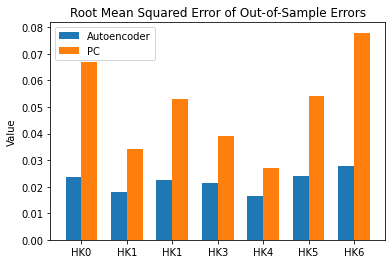

In [36]:
ar_width = 0.50
x = np.arange(7)
y1 = HKerror_out_rmsq
y2 = HK_RMSQ
bar_width = .35
# Plot the bars side by side
fig, ax = plt.subplots()
rects1 = ax.bar(x - bar_width/2, y1, bar_width, label='Autoencoder')
rects2 = ax.bar(x + bar_width/2, y2, bar_width, label='PC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Value')
ax.set_title('Root Mean Squared Error of Out-of-Sample Errors')
ax.set_xticks(x)
ax.set_xticklabels(['HK0', 'HK1', 'HK1', 'HK3', 'HK4', 'HK5', 'HK6'])
ax.legend()

plt.show()







- Lets import the Diebold-Mariano statistic to see if the out-of-sample errors are statically differenrt

In [37]:
def dm_test(actual_lst, pred1_lst, pred2_lst, h = 1, crit="MSE", power = 2):
    # Routine for checking errors
    def error_check():
        rt = 0
        msg = ""
        # Check if h is an integer
        if (not isinstance(h, int)):
            rt = -1
            msg = "The type of the number of steps ahead (h) is not an integer."
            return (rt,msg)
        # Check the range of h
        if (h < 1):
            rt = -1
            msg = "The number of steps ahead (h) is not large enough."
            return (rt,msg)
        len_act = len(actual_lst)
        len_p1  = len(pred1_lst)
        len_p2  = len(pred2_lst)
        # Check if lengths of actual values and predicted values are equal
        if (len_act != len_p1 or len_p1 != len_p2 or len_act != len_p2):
            rt = -1
            msg = "Lengths of actual_lst, pred1_lst and pred2_lst do not match."
            return (rt,msg)
        # Check range of h
        if (h >= len_act):
            rt = -1
            msg = "The number of steps ahead is too large."
            return (rt,msg)
        # Check if criterion supported
        if (crit != "MSE" and crit != "MAPE" and crit != "MAD" and crit != "poly"):
            rt = -1
            msg = "The criterion is not supported."
            return (rt,msg)  
        # Check if every value of the input lists are numerical values
        from re import compile as re_compile
        comp = re_compile("^\d+?\.\d+?$")  
        def compiled_regex(s):
            """ Returns True is string is a number. """
            if comp.match(s) is None:
                return s.isdigit()
            return True
        for actual, pred1, pred2 in zip(actual_lst, pred1_lst, pred2_lst):
            is_actual_ok = compiled_regex(str(abs(actual)))
            is_pred1_ok = compiled_regex(str(abs(pred1)))
            is_pred2_ok = compiled_regex(str(abs(pred2)))
            if (not (is_actual_ok and is_pred1_ok and is_pred2_ok)):  
                msg = "An element in the actual_lst, pred1_lst or pred2_lst is not numeric."
                rt = -1
                return (rt,msg)
        return (rt,msg)
    
    # Error check
    error_code = error_check()
    # Raise error if cannot pass error check
    if (error_code[0] == -1):
        raise SyntaxError(error_code[1])
        return
    # Import libraries
    from scipy.stats import t
    import collections
    import pandas as pd
    import numpy as np
    
    # Initialise lists
    e1_lst = []
    e2_lst = []
    d_lst  = []
    
    # convert every value of the lists into real values
    actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
    pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
    pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()
    
    # Length of lists (as real numbers)
    T = float(len(actual_lst))
    
    # construct d according to crit
    if (crit == "MSE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((actual - p1)**2)
            e2_lst.append((actual - p2)**2)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAD"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs(actual - p1))
            e2_lst.append(abs(actual - p2))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAPE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs((actual - p1)/actual))
            e2_lst.append(abs((actual - p2)/actual))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "poly"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(((actual - p1))**(power))
            e2_lst.append(((actual - p2))**(power))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)    
    
    # Mean of d        
    mean_d = pd.Series(d_lst).mean()
    
    # Find autocovariance and construct DM test statistics
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
              autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d_lst,len(d_lst),lag,mean_d)) # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    DM_stat=V_d**(-0.5)*mean_d
    harvey_adj=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DM_stat = harvey_adj*DM_stat
    # Find p-value
    p_value = 2*t.cdf(-abs(DM_stat), df = T - 1)
    
    # Construct named tuple for return
    dm_return = collections.namedtuple('dm_return', 'DM p_value')
    
    rt = dm_return(DM = DM_stat, p_value = p_value)
    
    return rt

In [40]:
Actual = HK_test
Actual = np.array(Actual)
PC = HK_out
PC = np.array(PC)
AC = HKtest_hat 
AC = np.array(AC)
actual_lst = Actual[:,0]
pred1_lst = PC[:,0]
pred2_lst = AC[:,0]
n_cols = Actual.shape[1];
DMSTAT = np.zeros(7)
DMPVAL = np.zeros(7)
for i in range(n_cols):
    actual_lst = Actual[:,i]
    pred1_lst = PC[:,i]
    pred2_lst = AC[:,i]
    dm_return = dm_test(actual_lst, pred1_lst, pred2_lst, h = 12, crit="MSE", power = 2)
    DMSTAT[i] = dm_return[0]
    DMPVAL[i] = dm_return[1]
    

print(DMPVAL)
    





[7.84341966e-27 9.43384013e-30 7.34263638e-35 1.86225778e-21
 4.67642024e-26 3.37882336e-26 3.20584163e-29]



$\textbf{t-Distributed Stochastic Neighbor Embedding (t-SNE)}$

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a dimensionality reduction technique commonly used for visualizing high-dimensional data in a lower-dimensional space, typically 2D. It was designed to address some of the limitations of PCA when dealing with complex, nonlinear datasets. t-SNE works by modeling the similarity between data points in high-dimensional space and a lower-dimensional space, optimizing for preserving local pairwise similarities.

The main steps in using t-SNE are as follows:

1. $\textit{Define Pairwise Similarities:}$ Calculate the pairwise similarities (usually using a Gaussian distribution) between data points in the high-dimensional space. These similarities represent how similar or dissimilar data points are to each other.

2. $\textit{Define Pairwise Similarities in Lower-Dimensional Space:}$ Similarly, calculate pairwise similarities in the lower-dimensional space. The goal is to make data points in the lower-dimensional space reflect the similarities as closely as possible to the high-dimensional space.

3. $\textit{Optimize for the Lower-Dimensional Embedding:}$ Use an optimization algorithm to minimize the divergence between the pairwise similarities in the high-dimensional space and the lower-dimensional space. t-SNE minimizes the Kullback-Leibler (KL) divergence to achieve this.


$\textbf{Kullback-Leibler (KL) Divergence}$

- The Kullback-Leibler (KL) divergence, also known as relative entropy, is a measure of how one probability distribution differs from a second, reference probability distribution. It quantifies the information lost when one distribution is used to approximate the other. For two probability distributions $P$ and $Q$, the KL divergence is defined as:

For discrete distributions:
$D_{\text{KL}}(P || Q) = \sum_x P(x) \log\left(\frac{P(x)}{Q(x)}\right)$

For continuous distributions:

$D_{\text{KL}}(P || Q) = \int P(x) \log\left(\frac{P(x)}{Q(x)}\right) \, dx$

Key properties and details:

$(D_{\text{KL}}(P || Q))$ is the KL divergence from probability distribution $P$ to probability distribution $Q$.

$P(x)$ and $Q(x)$ represent the probability densities or probability mass functions of the two distributions, evaluated at the point $x$.

- The summation or integration is performed over all possible values of $x$ in the domain of the distributions.
- The KL divergence is always non-negative, meaning $(D_{\text{KL}}(P || Q) \geq 0$.
- It is not symmetric, which means $(D_{\text{KL}}(P || Q) \neq D_{\text{KL}}(Q || P)$.
- KL divergence measures the extra average number of bits needed to code samples from $P$ using a code optimized for $Q$.
- When $P$ and $Q$ are identical, the KL divergence is zero, indicating no information loss, i.e., $D_{\text{KL}}(P || P) = 0$.

- The KL divergence is widely used in various machine learning applications, including optimization, probabilistic modeling, and information retrieval. It's used to quantify the difference between probability distributions, making it a valuable tool for tasks such as model comparison, feature selection, and evaluation of generative models.



While t-SNE is incredibly effective at visualizing high-dimensional data in a reduced 2D or 3D space, it's not a technique primarily used for data compression. It doesn't create a compact representation of the data, as PCA does. Instead, it focuses on preserving the structure and relationships among data points.

If you want to perform data compression or feature reduction while retaining most of the important information, PCA or other dimensionality reduction techniques would be more appropriate choices. These methods aim to represent the data in a lower-dimensional space while minimizing information loss, making them more suitable for data compression and feature engineering.




In [ ]:
from sklearn.manifold import TSNE
import numpy as np

# Generate some example data

XX = USA

# Initialize and fit the t-SNE model
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=5000)
XX_tsne = tsne.fit_transform(XX)

# Visualize the results
import matplotlib.pyplot as plt
plt.scatter(XX_tsne[:, 0], XX_tsne[:, 1])
plt.show()

In [ ]:
plt.plot(Date, XX_tsne)
plt.title('TSNE Components')


$\textbf{K-Nearest Neighbors (K-NN)}$

K-Nearest Neighbors (K-NN) is a machine learning algorithm used for classification and regression tasks. It makes predictions based on the similarity of input data points to those in the training dataset.

$\textit{How it works:}$

- Training Phase: The algorithm stores the entire training dataset in memory.
- Prediction Phase:
  
- - Calculates the distance between the new data point and all data points in the training dataset using a chosen distance metric.
- - item Identifies the K data points (K-nearest neighbors) closest to the new data point.
- - For classification, it takes a majority vote among the K-nearest neighbors to determine the predicted class.
- - For regression, it computes the average (or weighted average) of the target values of the K-nearest neighbors to predict the target value.


$\textit{Key points:}$

- The choice of distance metric and the value of K are crucial.
- K-NN can be computationally intensive with large datasets.
- It's simple and intuitive but may not perform well in high-dimensional spaces.
- K-NN is a lazy learning algorithm with no explicit training phase.

$\underline{K-Nearest Neighbors (K-NN) for Dimensionality Reduction}

1. Feature Selection:
   - You can use K-NN to evaluate the importance of different features in your dataset.
   - By analyzing the impact of individual features on the K-NN model's performance, you can identify and select a subset of the most relevant features.
   - This feature selection process effectively reduces the dimensionality of your data.

2. Nearest Neighbors for Clustering:
   - In some cases, K-NN can be used for clustering similar data points in high-dimensional space.
   - By clustering data points that are close to each other, you may identify groups of features that can be considered together, potentially reducing dimensionality.

However, it's important to note that K-NN is not a primary technique for dimensionality reduction. PCA and other dimensionality reduction techniques like t-Distributed Stochastic Neighbor Embedding (t-SNE) and Linear Discriminant Analysis (LDA) are better suited for this purpose. These techniques are explicitly designed to capture and represent data in a lower-dimensional space while preserving the most important information, which is not the primary goal of K-NN.
You can now copy and paste this information as needed.















In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def knn_compression(X, k):
    """
    Performs k-nearest neighbor data compression on a large N by K matrix X.

    Parameters:
    X (numpy.ndarray): The N by K matrix to be compressed.
    k (int): The number of nearest neighbors to consider.

    Returns:
    compressed_X (numpy.ndarray): The compressed N by k matrix.
    """

    # Find the k nearest neighbors for each data point
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)

    # Compute the mean of the k nearest neighbors for each data point
    compressed_X = np.zeros((X.shape[0], X.shape[1]))
    for i in range(X.shape[0]):
        compressed_X[i,:] = np.mean(X[indices[i,:],:], axis=0)

    # Select the first k columns of the compressed matrix
    compressed_X = compressed_X[:,:k]

    return compressed_X



In [ ]:
USA_compressed = knn_compression(USA,4)

In [ ]:
print(USA_compressed.shape)


In [ ]:
plt.plot(Date, USA_compressed)
plt.title('K-Nearest Neighbor')

In [ ]:
import numpy as np

def standardize(X):
    """
    Standardizes a large N by K matrix X.

    Parameters:
    X (numpy.ndarray): The N by K matrix to be standardized.

    Returns:
    X_std (numpy.ndarray): The standardized N by K matrix.
    """

    # Calculate the mean and standard deviation of each column
    col_mean = np.mean(X, axis=0)
    col_std = np.std(X, axis=0)

    # Subtract the mean from each column and divide by the standard deviation
    X_std = (X - col_mean) / col_std

    return X_std


In [ ]:
USAstd = standardize(USA)

In [ ]:
plt.plot(Date, USAstd)

In [ ]:
import numpy as np
from sklearn.decomposition import FactorAnalysis

def factor_analysis(X, n_components):
    """
    Performs dynamic factor analysis on a large n by k matrix X.

    Parameters:
    X (numpy.ndarray): The n by k matrix to be analyzed.
    n_components (int): The number of factors to extract.

    Returns:
    transformed_X (numpy.ndarray): The transformed n by n_components matrix.
    """

    # Fit a factor analysis model to the data
    fa = FactorAnalysis(n_components=n_components).fit(X)

    # Transform the data using the factor analysis model
    transformed_X = fa.transform(X)

    return transformed_X


In [ ]:
USA_factors = factor_analysis(USAstd,2)

In [ ]:
plt.plot(Date, USA_factors)

In [ ]:
import numpy as np
from scipy.linalg import eig

def dynamic_factor_analysis(X, n_factors, n_lags):
    """
    Performs dynamic factor analysis on a large n by k matrix X.

    Parameters:
    X (numpy.ndarray): The n by k matrix to be analyzed.
    n_factors (int): The number of factors to extract.
    n_lags (int): The number of time lags to use.

    Returns:
    transformed_X (numpy.ndarray): The transformed n by n_factors matrix.
    """

    # Construct lagged matrix
    n_obs = X.shape[0]
    lagged_X = np.zeros((n_obs - n_lags, n_lags * X.shape[1]))
    for i in range(n_lags):
        lagged_X[:, i*X.shape[1]:(i+1)*X.shape[1]] = X[i:n_obs-n_lags+i, :]

    # Perform eigenvalue decomposition of lagged matrix
    cov = np.cov(lagged_X, rowvar=False)
    eigenvals, eigenvecs = eig(cov)

    # Select the largest eigenvalues and eigenvectors
    indices = np.argsort(eigenvals)[::-1][:n_factors]
    factor_vecs = eigenvecs[:, indices]

    # Compute factor loadings and transform data
    factor_loadings = np.zeros((X.shape[1], n_factors))
    transformed_X = np.zeros((n_obs - n_lags, n_factors))
    for i in range(n_factors):
        factor_loadings[:, i] = np.mean(lagged_X.dot(factor_vecs[:, i]), axis=0)
        transformed_X[:, i] = X[n_lags:, :].dot(factor_loadings[:, i])

    return transformed_X


In [ ]:
USA_dfn = dynamic_factor_analysis(USAstd,2,1)

In [ ]:
print(USA_dfn.shape)

In [ ]:
print(Date.shape)

In [ ]:
Date1 = Date[1:]

In [ ]:
plt.plot(Date1, USA_dfn)